# Modeling and the Temperature of the Earth with the Atmosphere using Absorption Spectra Data

In [126]:
# Import Libraries
import pandas as pd
import math
import numpy as np
from typing import Callable
import functools
import bisect
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from Unit0 import model_utils

In [127]:
# Constants
plancks_constant = 6.62607015e-34
speed_of_light = 299792458
boltzmann_constant = 1.380649e-23

absorption_components = ["H2O", "CO2", "CH4", "O3", "N2O", "N2", "O2"]
wavelengths = np.linspace(0.1e-6, 40e-6, 399001)
temperature_sun = 5772
steradian_sun = 6.794e-5
radius_earth = 6.371e6

In [128]:
# Define Calculation Functions
def plancks_law(wavelength: float, temperature: float) -> float:
    return 2 * plancks_constant * speed_of_light ** 2 / wavelength ** 5 / math.expm1(plancks_constant * speed_of_light / wavelength / boltzmann_constant / temperature)


def spectral_radiance(wavelength: float, temperature: float, transmittances_for_wavelength: list[float]) -> float:
    return plancks_law(wavelength, temperature) * functools.reduce(lambda x, y: x * y, transmittances_for_wavelength)


def radiance_from_spectral(wavelengths: list[float], spectral_radiances: list[float]) -> float:
    delta_wavelength = wavelengths[1] - wavelengths[0]
    return functools.reduce(lambda x, y: x + y, map(lambda x: x * delta_wavelength, spectral_radiances))


def radiance(wavelengths: list[float], temperature: float, transmittances: list[list[float]]) -> float:
    return radiance_from_spectral(wavelengths, [spectral_radiance(wavelength, temperature, transmittances_for_wavelength) for wavelength, transmittances_for_wavelength in zip(wavelengths, transmittances)])

In [129]:
# Load Data
data1 = pd.read_csv("Data/Absorption 0.1-3 Microns.csv")
data2 = pd.read_csv("Data/Absorption 3-12 Microns.csv")
data3 = pd.read_csv("Data/Absorption 12-40 Microns.csv")

In [130]:
# Processes data into lists of tuples of wavelength and transmittance
def load_transmittance_for_component(data: pd.DataFrame, wavelength_key: str, component: str):
    return list(filter(lambda x: not math.isnan(x[0]) and not math.isnan(x[1]), zip(map(lambda x: x * 1e-6, data[wavelength_key]), data[f"{component} Transmittance"])))


transmittances = [load_transmittance_for_component(data1, f"{component} Wavelength (microns)", component) + load_transmittance_for_component(data2, "Wavelength (microns)", component) + load_transmittance_for_component(data3, "Wavelength (microns)", component) for component in absorption_components]

In [131]:
# Finds value in a less than or equal to x
def find_le[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect(a, x, key=key)
    return a[i - 1 if i else 0]


# Finds value in a greater than or equal to x
def find_ge[T, K](a: list[T], x: K, key: Callable[[T], K]) -> T:
    i = bisect.bisect_left(a, x, key=key)
    return a[i if i < len(a) else i - 1]


# Interpolates value of x based on lower and upper bounds in a
def interpolate[K, V](a: list[tuple[K, V]], x: K) -> V:
    key: Callable[[tuple[K, V]], K] = lambda p: p[0]
    value: Callable[[tuple[K, V]], V] = lambda p: p[1]
    p0: tuple[K, V] = find_le(a, x, key)
    p1: tuple[K, V] = find_ge(a, x, key)
    x0: K = key(p0)
    x1: K = key(p1)
    y0: V = value(p0)
    if x0 == x1:
        return y0
    y1: V = value(p1)
    return y0 + (y1 - y0) / (x1 - x0) * (x - x0)

100%|██████████| 399001/399001 [00:06<00:00, 59124.42it/s]


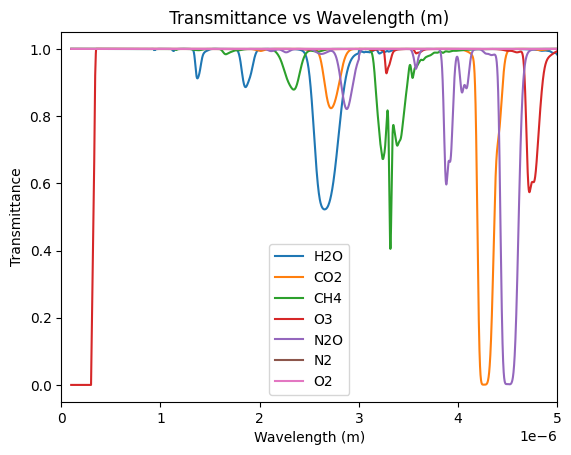

In [132]:
# Interpolate Transmittances
transmittances_interpolated = [[interpolate(transmittance, wavelength) for transmittance in transmittances] for wavelength in tqdm(wavelengths)]

plt.xlim(0, 5e-6)
model_utils.graph([(wavelengths, list(map(lambda x: x[i], transmittances_interpolated)), absorption_component) for i, absorption_component in enumerate(absorption_components)], "Transmittance", "", "Wavelength", "m")

In [133]:
# Calculate Solar Spectral Radiance
spectral_radiance_sun_without_transmittances = [plancks_law(wavelength, temperature_sun) * steradian_sun for wavelength in tqdm(wavelengths)]
spectral_radiance_sun = [spectral_radiance(wavelength, temperature_sun, transmittances_for_wavelength) * steradian_sun for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), transmittances_interpolated)]

100%|██████████| 399001/399001 [00:00<00:00, 946933.40it/s]


In [134]:
# Calculate Solar Radiance
radiance_sun_without_transmittances = radiance_from_spectral(wavelengths, spectral_radiance_sun_without_transmittances)
radiance_sun = radiance_from_spectral(wavelengths, spectral_radiance_sun)

print(f"Radiance of the Sun without Absorption: {radiance_sun_without_transmittances} W/m^2")
print(f"Radiance of the Sun with Absorption: {radiance_sun} W/m^2")

# Calculate Solar Power
power_sun_without_transmittances = radiance_sun_without_transmittances * math.pi * radius_earth ** 2
power_sun = radiance_sun * math.pi * radius_earth ** 2

print(f"Power of the Sun without Absorption: {power_sun_without_transmittances} W")
print(f"Power of the Sun with Absorption: {power_sun} W")

Radiance of the Sun without Absorption: 1361.0917733830372 W/m^2
Radiance of the Sun with Absorption: 1276.080672553739 W/m^2
Power of the Sun without Absorption: 1.73561139152844e+17 W
Power of the Sun with Absorption: 1.627208535901026e+17 W


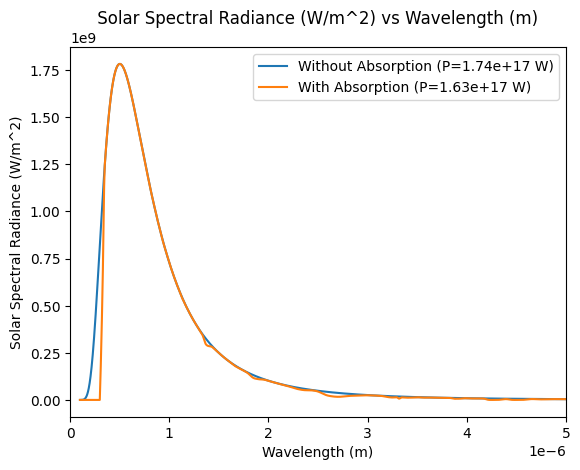

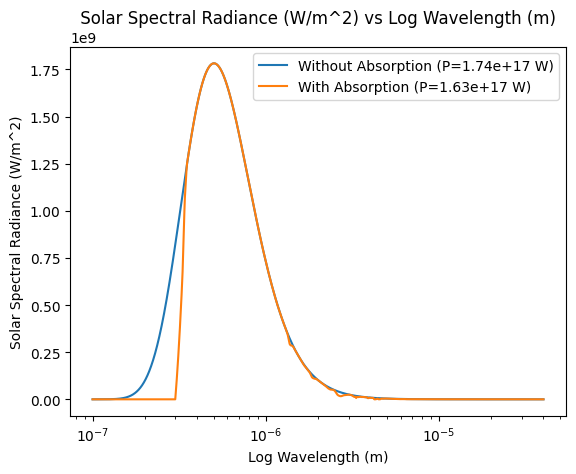

In [135]:
# Graph Solar Spectral Radiance
plt.xlim(0, 5e-6)
model_utils.graph([(wavelengths, spectral_radiance_sun_without_transmittances, f"Without Absorption (P={power_sun_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_sun, f"With Absorption (P={power_sun:.2e} W)")], "Solar Spectral Radiance", "W/m^2", "Wavelength", "m")
plt.xscale("log")
model_utils.graph([(wavelengths, spectral_radiance_sun_without_transmittances, f"Without Absorption (P={power_sun_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_sun, f"With Absorption (P={power_sun:.2e} W)")], "Solar Spectral Radiance", "W/m^2", "Log Wavelength", "m")

In [136]:
def power_earth_of(temperature: float) -> float:
    return radiance(wavelengths, temperature, transmittances_interpolated) * 4 * math.pi ** 2 * radius_earth ** 2


def binary_search(value: Callable[[float], float], target: float, left: float, right: float) -> float:
    while right - left > 1e-2:
        mid = (left + right) / 2
        power = value(mid)
        if power < target:
            left = mid
        else:
            right = mid
    return (left + right) / 2

# Fit Earth Power
temperature_earth = binary_search(power_earth_of, power_sun, 0, 1000)
print(f"Temperature of the Earth: {temperature_earth} K")

Temperature of the Earth: 299.1828918457031 K


In [137]:
# Calculate Earth Spectral Radiance
spectral_radiance_earth_without_transmittances = [plancks_law(wavelength, temperature_earth) * 4 * math.pi for wavelength in tqdm(wavelengths)]
spectral_radiance_earth = [spectral_radiance(wavelength, temperature_earth, transmittances_for_wavelength) * 4 * math.pi for wavelength, transmittances_for_wavelength in zip(tqdm(wavelengths), transmittances_interpolated)]

100%|██████████| 399001/399001 [00:00<00:00, 889901.78it/s]


In [138]:
# Calculate Earth Radiance
radiance_earth_without_transmittances = radiance_from_spectral(wavelengths, spectral_radiance_earth_without_transmittances)
radiance_earth = radiance_from_spectral(wavelengths, spectral_radiance_earth)

print(f"Radiance of the Earth without Absorption: {radiance_earth_without_transmittances} W/m^2")
print(f"Radiance of the Earth with Absorption: {radiance_earth} W/m^2")

# Calculate Earth Power
power_earth_without_transmittances = radiance_earth_without_transmittances * math.pi * radius_earth ** 2
power_earth = radiance_earth * math.pi * radius_earth ** 2

print(f"Power of the Earth without Absorption: {power_earth_without_transmittances} W")
print(f"Power of the Earth with Absorption: {power_earth} W")

Radiance of the Earth without Absorption: 1716.7315287416245 W/m^2
Radiance of the Earth with Absorption: 1276.1326510427823 W/m^2
Power of the Earth without Absorption: 2.1891094015462003e+17 W
Power of the Earth with Absorption: 1.627274816852437e+17 W


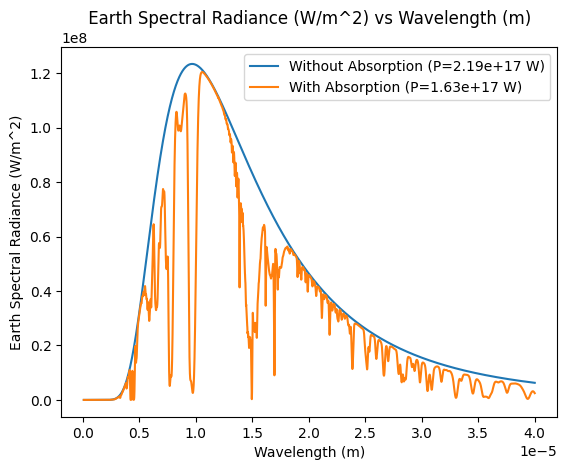

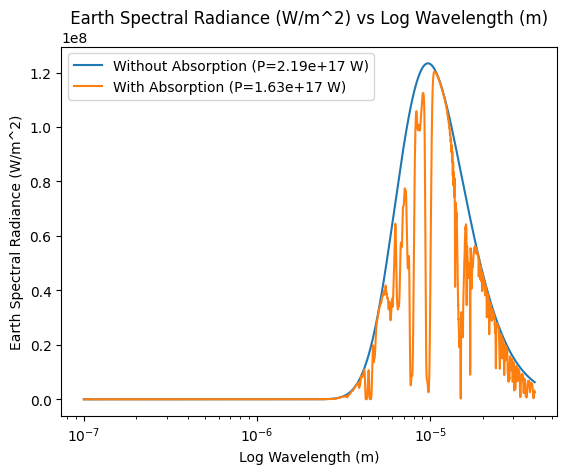

In [139]:
# Graph Earth Spectral Radiance
model_utils.graph([(wavelengths, spectral_radiance_earth_without_transmittances, f"Without Absorption (P={power_earth_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_earth, f"With Absorption (P={power_earth:.2e} W)")], "Earth Spectral Radiance", "W/m^2", "Wavelength", "m")
plt.xscale("log")
model_utils.graph([(wavelengths, spectral_radiance_earth_without_transmittances, f"Without Absorption (P={power_earth_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_earth, f"With Absorption (P={power_earth:.2e} W)")], "Earth Spectral Radiance", "W/m^2", "Log Wavelength", "m")

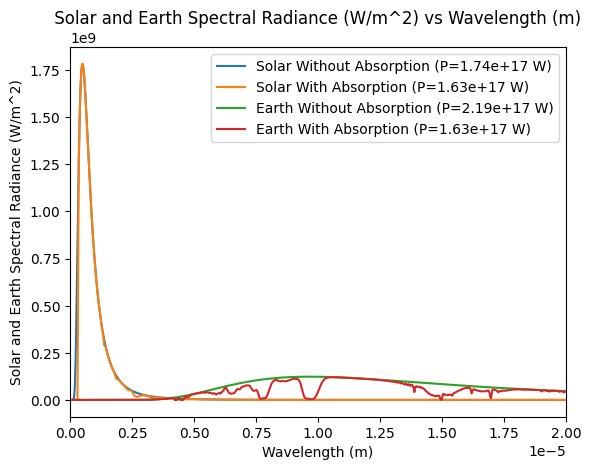

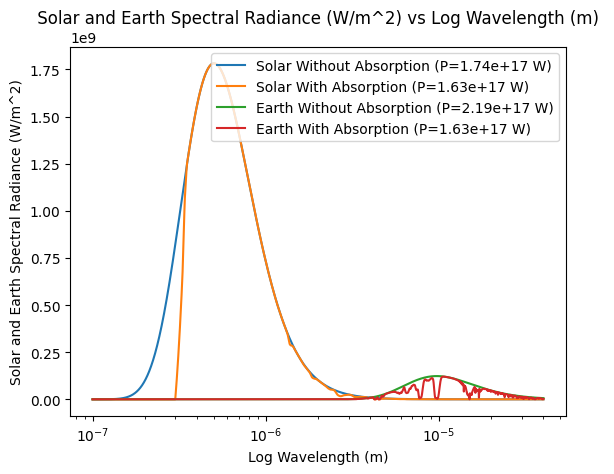

In [140]:
# Graph Solar and Earth Spectral Radiance
plt.xlim(0, 2e-5)
model_utils.graph([(wavelengths, spectral_radiance_sun_without_transmittances, f"Solar Without Absorption (P={power_sun_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_sun, f"Solar With Absorption (P={power_sun:.2e} W)"), (wavelengths, spectral_radiance_earth_without_transmittances, f"Earth Without Absorption (P={power_earth_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_earth, f"Earth With Absorption (P={power_earth:.2e} W)")], "Solar and Earth Spectral Radiance", "W/m^2", "Wavelength", "m")
plt.xscale("log")
model_utils.graph([(wavelengths, spectral_radiance_sun_without_transmittances, f"Solar Without Absorption (P={power_sun_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_sun, f"Solar With Absorption (P={power_sun:.2e} W)"), (wavelengths, spectral_radiance_earth_without_transmittances, f"Earth Without Absorption (P={power_earth_without_transmittances:.2e} W)"), (wavelengths, spectral_radiance_earth, f"Earth With Absorption (P={power_earth:.2e} W)")], "Solar and Earth Spectral Radiance", "W/m^2", "Log Wavelength", "m")